In [1]:
%load_ext autoreload
%autoreload 2

from code_py.DIAMOnD import *
from code_py.backbone import Human_Genes_Graph_Analysis
import markov_clustering as mc
from joblib import Parallel, delayed
import statistics 
from tqdm import tqdm

sys_path = '/Users/tanselsimsek/Desktop/DS/2.1/BI/Final_project/'


#  Part 1: Preprocessing

In [2]:
disease_code = "C0020796"
hga = Human_Genes_Graph_Analysis(sys_path,disease_ID = disease_code)

#### 1.1 -- Filtering and revoving self-loops

In [3]:
# Preprocessing the Biogrid dataset by filtering Homo Sapiens, removing duplicated and self loops
hs_putative_genes = hga.preprocessing_dataset(homo_sap=True,drop_duplicates=True,remove_self_loops=True)

Number of putative genes: 889884


#### 1.2 -- Filtering Disease Genes

In [4]:
hs_disease_genes_df,hs_disease_genes = hga.query_disease_genes()

Found 139 disease genes in Profound Mental Retardation


#### 1.3 -- Creating LCC sub-graph,adjacency matrix,

In [5]:
# We are creating the graph with nx from the from the filtered PPI dataset and returning the sub graph, adj matrix, nodes and edges of LCC 
pgenes_sub_graph,pgenes_adj,pnodes,pedges = hga.LCC_to_adj(hs_putative_genes)

# of connected components: 1
19618
Name: 
Type: Graph
Number of nodes: 19618
Number of edges: 665061
Average degree:  67.8011


#### 1.3 -- Cross Validation

In [6]:
ds_genes_train,ds_genes_test = hga.KFold_CV(hs_disease_genes,n_folds=5,shuffle_flag=True)

#### 1.4 -- Saving Seed Genes to files for Cytoscape

In [9]:
for i in range(len(ds_genes_test)):
    np.savetxt("test"+str(i)+".csv", 
            ds_genes_test[i],
            delimiter =", ", 
            fmt ='% s')
    np.savetxt("train"+str(i)+".csv", 
            ds_genes_train[i],
            delimiter =", ", 
            fmt ='% s')

# Part 2: Algorithms  

### 2.1 -- MCL Algorithm 

In [14]:
# Applying MLC Algoritm by given inflation range (1.5, 2.7, step = 0.1)
results = Parallel(n_jobs=3)(delayed(hga.MCL)(pgenes_adj,i) for i in tqdm(np.arange(1.5,2.7,0.1)))


100%|██████████| 13/13 [7:31:19<00:00, 2083.00s/it] 


In [15]:
hga.list_to_pikle(results,'MLC_modularity')

In [16]:
results_list_from_pkl = hga.read_pickle_list('MLC_modularity')
for i in enumerate(np.arange(1.5,2.7,0.1)):
    print("inflation:", round(i[1],2), "modularity:", results_list_from_pkl[i[0]])
    

inflation: 1.5 modularity: 0.7318793908083768
inflation: 1.6 modularity: 0.7664038191128469
inflation: 1.7 modularity: 0.7948113431834943
inflation: 1.8 modularity: 0.8254253707325344
inflation: 1.9 modularity: 0.8034790682066575
inflation: 2.0 modularity: 0.7514658577401434
inflation: 2.1 modularity: 0.6951036602617071
inflation: 2.2 modularity: 0.641935117124079
inflation: 2.3 modularity: 0.5919604667312881
inflation: 2.4 modularity: 0.5541978925627196
inflation: 2.5 modularity: 0.5206722692342249
inflation: 2.6 modularity: 0.49161128642816465
inflation: 2.7 modularity: 0.46866783664642075


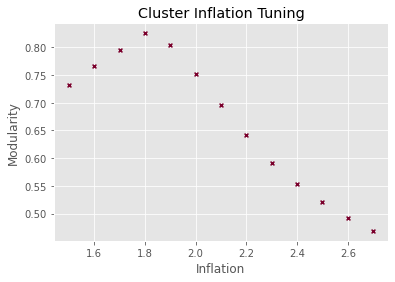

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = np.arange(1.5,2.7,0.1)
y = results_list_from_pkl
plt.scatter(x,y,color="#7b002c",s=15,marker='x')
x,y = 1.7, 0.4
plt.xlabel("Inflation")
plt.ylabel("Modularity")
plt.title('Cluster Inflation Tuning')
plt.show()

### 2.1.1 -- Creating Clusters

In [11]:
best_inflation = 1.8
result = mc.run_mcl(pgenes_adj, inflation=best_inflation)
clusters = mc.get_clusters(result)
print(str(len(clusters))+" of clusters obtained with inflation of "+str(best_inflation))

2106 of clusters obtained with inflation of 1.8


In [12]:
_, enriched_genes,enriched_cluster_ID = hga.MLC_eval(pgenes_sub_graph,ds_genes_train,clusters)

Fold number:  0
6 disease genes in cluster 0 --> 0.165607
35 disease genes in cluster 2 --> 0.013666
3 disease genes in cluster 6 --> 0.217906
6 disease genes in cluster 11 --> 0.165457
3 disease genes in cluster 27 --> 0.034026
4 disease genes in cluster 46 --> 0.154399
7 disease genes in cluster 53 --> 0.115389
3 disease genes in cluster 68 --> 0.127471
Fold number:  1
5 disease genes in cluster 0 --> 0.164454
40 disease genes in cluster 2 --> 0.001084
3 disease genes in cluster 6 --> 0.217906
6 disease genes in cluster 11 --> 0.165457
8 disease genes in cluster 53 --> 0.073821
3 disease genes in cluster 67 --> 0.22377
3 disease genes in cluster 68 --> 0.127471
Fold number:  2
3 disease genes in cluster 0 --> 0.087338
34 disease genes in cluster 2 --> 0.020074
4 disease genes in cluster 6 --> 0.136394
7 disease genes in cluster 11 --> 0.139195
10 disease genes in cluster 53 --> 0.020798
3 disease genes in cluster 67 --> 0.22377
3 disease genes in cluster 68 --> 0.127471
Fold number: 

In [66]:
hga.MCL_evaluation_metrics(pgenes_sub_graph,ds_genes_test,hs_disease_genes,clusters,enriched_cluster_ID)

TP: 51 --- FP: 2055 --- FN: 19567
Precision: 0.024217 --- Recall: 0.0026 --- F1 Score: 0.004695


### 2.2 -- DIAMOnD Algorithm

#### --- new implementation ---

In [32]:
def return_pre_recall(predicted_nodes, ds_genes_train, ds_genes_test):
    precision_50 = []
    precision_n_10 = []
    precision_n_4 = []
    precision_n_2 = []
    precision_n = []
    TP_50 = len(set(predicted_nodes[:50]).intersection(set(ds_genes_test)))
    TP_n_10 = len(set(predicted_nodes[:n//10]).intersection(set(ds_genes_test)))
    TP_n_4 = len(set(predicted_nodes[:n//4]).intersection(set(ds_genes_test)))
    TP_n_2 = len(set(predicted_nodes[:n//2]).intersection(set(ds_genes_test)))
    TP_n = len(set(predicted_nodes[:min(n, len(predicted_nodes))]).intersection(set(ds_genes_test)))
    FP_50 = len(ds_genes_train) - TP_50
    FP_n_10 = len(ds_genes_train) - TP_n_10
    FP_n_4 = len(ds_genes_train) - TP_n_4
    FP_n_2 = len(ds_genes_train) - TP_n_2
    FP_n = len(ds_genes_train) - TP_n
    FN_50 = len(ds_genes_test) - TP_50
    FN_n_10 = len(ds_genes_test) - TP_n_10
    FN_n_4 = len(ds_genes_test) - TP_n_4
    FN_n_2 = len(ds_genes_test) - TP_n_2
    FN_n = len(ds_genes_test) - TP_n
    
    return TP_50/(TP_50+FP_50), TP_n_10/(TP_n_10+FP_n_10), TP_n_4/(TP_n_4+FP_n_4), TP_n_2/(TP_n_2+FP_n_2), TP_n/(TP_n+FP_n), TP_50/(TP_50+FN_50), TP_n_10/(TP_n_10+FN_n_10), TP_n_4/(TP_n_4+FN_n_4), TP_n_2/(TP_n_2+FN_n_2), TP_n/(TP_n+FN_n) 

In [39]:
precision_50 = []
precision_n_10 = []
precision_n_4 = []
precision_n_2 = []
precision_n = []
recall_50 = []
recall_n_10 = []
recall_n_4 = []
recall_n_2 = []
recall_n = []
f1_score_50 = []
f1_score_n_10 = []
f1_score_n_4 = []
f1_score_n_2 = []
f1_score_n = []
ndcg_50 = []
ndcg_n_10 = []
ndcg_n_4 = []
ndcg_n_2 = []
ndcg_n = []
n = len(hs_disease_genes)
for i in range(0,5):
    added_nodes, predicted_nodes = DIAMOnD(G_original=pgenes_sub_graph,
                            seed_genes=ds_genes_train[i],
                            max_number_of_added_nodes=len(ds_genes_train[i]),alpha=1)
    #TP numero di geni che effettivamente sono disease genes
    pre_50, pre_n_10, pre_n_4, pre_n_2, pre_n, rec_50, rec_n_10, rec_n_4, rec_n_2, rec_n = return_pre_recall(predicted_nodes, ds_genes_train[i], ds_genes_test[i])
    precision_50.append(pre_50); precision_n_10.append(pre_n_10); precision_n_4.append(pre_n_4); precision_n_2.append(pre_n_2); precision_n.append(pre_n)
    recall_50.append(rec_50); recall_n_10.append(rec_n_10); recall_n_4.append(rec_n_4); recall_n_2.append(rec_n_2); recall_n.append(rec_n)
    ndcg_50.append(hga.ndcg(predicted_nodes, ds_genes_test[i], 50))
    ndcg_n_10.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//10))
    ndcg_n_4.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//4))
    ndcg_n_2.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//2))
    ndcg_n.append(hga.ndcg(predicted_nodes, ds_genes_test[i], min(n, len(predicted_nodes))))
    try:
        f1_score_50.append((2*pre_50*rec_50)/(pre_50+rec_50))
    except:
        print("zero division")
    try:
        f1_score_n_10.append((2*pre_n_10*rec_n_10)/(pre_n_10+rec_n_10))
    except:
        print("zero division")
    try:
        f1_score_n_4.append((2*pre_n_4*rec_n_4)/(pre_n_4+rec_n_4))
    except:
        print("zero division")
    try:
        f1_score_n_2.append((2*pre_n_2*rec_n_2)/(pre_n_2+rec_n_2))
    except:
        print("zero division")
    try:
        f1_score_n.append((2*pre_n*rec_n)/(pre_n+rec_n))
    except:
        print("zero division")


print("Precision at 50: " + str(round(statistics.mean(precision_50),6)) + " ± " +str(round(statistics.stdev(precision_50),6)))
print("Precision at n/10: " + str(round(statistics.mean(precision_n_10),6)) + " ± " +str(round(statistics.stdev(precision_n_10),6)))
print("Precision at n/4: " + str(round(statistics.mean(precision_n_4),6)) + " ± " +str(round(statistics.stdev(precision_n_4),6)))
print("Precision at n/2: " + str(round(statistics.mean(precision_n_2),6)) + " ± " +str(round(statistics.stdev(precision_n_2),6)))
print("Precision at n: " + str(round(statistics.mean(precision_n),6)) + " ± " +str(round(statistics.stdev(precision_n),6)))
print("Recall at 50: " + str(round(statistics.mean(recall_50),6)) + " ± " +str(round(statistics.stdev(recall_50),6)))
print("Recall at n/10: " + str(round(statistics.mean(recall_n_10),6)) + " ± " +str(round(statistics.stdev(recall_n_10),6)))
print("Recall at n/4: " + str(round(statistics.mean(recall_n_4),6)) + " ± " +str(round(statistics.stdev(recall_n_4),6)))
print("Recall at n/2: " + str(round(statistics.mean(recall_n_2),6)) + " ± " +str(round(statistics.stdev(recall_n_2),6)))
print("Recall at n: " + str(round(statistics.mean(recall_n),6)) + " ± " +str(round(statistics.stdev(recall_n),6)))
try:
    print("F1 Score at 50: " + str(round(statistics.mean(f1_score_50),6)) + " ± " +str(round(statistics.stdev(f1_score_50),6)))
except:
    print("F1 Score at 50: " + str(round(statistics.mean(f1_score_50),6)))
try:
    print("F1 Score at n/10: " + str(round(statistics.mean(f1_score_n_10),6)) + " ± " +str(round(statistics.stdev(f1_score_n_10),6)))
except:
    print("F1 Score at n/10: " + str(round(statistics.mean(f1_score_n_10),6)))
try:
    print("F1 Score at n/4: " + str(round(statistics.mean(f1_score_n_4),6)) + " ± " +str(round(statistics.stdev(f1_score_n_4),6)))
except:
    print("F1 Score at n/4: " + str(round(statistics.mean(f1_score_n_4),6)))
try:
    print("F1 Score at n/2: " + str(round(statistics.mean(f1_score_n_2),6)) + " ± " +str(round(statistics.stdev(f1_score_n_2),6)))
except:
    print("F1 Score at n/2: " + str(round(statistics.mean(f1_score_n_2),6)))
try: 
    print("F1 Score at n: " + str(round(statistics.mean(f1_score_n),6)) + " ± " +str(round(statistics.stdev(f1_score_n),6)))
except:
    print("F1 Score at n: " + str(round(statistics.mean(f1_score_n),6)) + " ± " +str(round(statistics.stdev(f1_score_n),6)))
print("nDCG at 50: " + str(round(statistics.mean(ndcg_50),6)) + " ± " +str(round(statistics.stdev(ndcg_50),6)))
print("nDCG at n/10: " + str(round(statistics.mean(ndcg_n_10),6)) + " ± " +str(round(statistics.stdev(ndcg_n_10),6)))
print("nDCG at n/4: " + str(round(statistics.mean(ndcg_n_4),6)) + " ± " +str(round(statistics.stdev(ndcg_n_4),6)))
print("nDCG at n/2: " + str(round(statistics.mean(ndcg_n_2),6)) + " ± " +str(round(statistics.stdev(ndcg_n_2),6)))
print("nDCG at n: " + str(round(statistics.mean(ndcg_n),6)) + " ± " +str(round(statistics.stdev(ndcg_n),6)))

DIAMOnD(): ignoring 5 of 111 seed genes that are not in the network
DiaBLE(): ignoring 5 of 111 seed genes that are not in the network
zero division
zero division
zero division
DIAMOnD(): ignoring 3 of 111 seed genes that are not in the network
DiaBLE(): ignoring 3 of 111 seed genes that are not in the network
zero division
zero division
zero division
zero division
zero division
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
zero division
zero division
zero division
zero division
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 112 seed genes that are not in the network
DiaBLE(): ignoring 4 of 112 seed genes that are not in the network
zero division
zero division
zero division
zero division
Precision at 50: 0.001802 ± 0.004029
Precision at n/10: 0.001802 ± 0.004029
Precision at n/4: 0.00180

In [43]:
precision = []
recall = []
f1_score = []
ndcg_50 = []
ndcg_n_10 = []
ndcg_n_4 = []
ndcg_n_2 = []
ndcg_n = []
n = len(hs_disease_genes)
for i in range(0,5):
    added_nodes, predicted_nodes = DIAMOnD(G_original=pgenes_sub_graph,
                            seed_genes=ds_genes_train[i],
                            max_number_of_added_nodes=len(ds_genes_train[i]),alpha=1)
    #TP numero di geni che effettivamente sono disease genes
    TP = len(set(predicted_nodes).intersection(set(ds_genes_test[i])))
    #numero di geni riportati come veri ma che non sono disease genes 
    FP = len(ds_genes_train[i]) - TP
    FN = len(ds_genes_test[i]) - TP
    precision.append(TP/(TP+FP))
    recall.append((TP)/(TP+FN))
    ndcg_50.append(hga.ndcg(predicted_nodes, ds_genes_test[i], 50))
    ndcg_n_10.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//10))
    ndcg_n_4.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//4))
    ndcg_n_2.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//2))
    ndcg_n.append(hga.ndcg(predicted_nodes, ds_genes_test[i], min(n, len(predicted_nodes))))
    try:
        f1_score.append((2*precision[i]*recall[i])/(precision[i]+recall[i]))
    except:
        print("zero division")


print("Precision: " + str(round(statistics.mean(precision),6)) + " ± " +str(round(statistics.stdev(precision),6)))
print("Recall: " + str(round(statistics.mean(recall),6)) + " ± " +str(round(statistics.stdev(recall),6)))
print("F1 Score: " + str(round(statistics.mean(f1_score),6)) + " ± " +str(round(statistics.stdev(f1_score),6)))
print("nDCG at 50: " + str(round(statistics.mean(ndcg_50),6)) + " ± " +str(round(statistics.stdev(ndcg_50),6)))
print("nDCG at n/10: " + str(round(statistics.mean(ndcg_n_10),6)) + " ± " +str(round(statistics.stdev(ndcg_n_10),6)))
print("nDCG at n/4: " + str(round(statistics.mean(ndcg_n_4),6)) + " ± " +str(round(statistics.stdev(ndcg_n_4),6)))
print("nDCG at n/2: " + str(round(statistics.mean(ndcg_n_2),6)) + " ± " +str(round(statistics.stdev(ndcg_n_2),6)))
print("nDCG at n: " + str(round(statistics.mean(ndcg_n),6)) + " ± " +str(round(statistics.stdev(ndcg_n),6)))


DIAMOnD(): ignoring 5 of 111 seed genes that are not in the network
DiaBLE(): ignoring 5 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 3 of 111 seed genes that are not in the network
DiaBLE(): ignoring 3 of 111 seed genes that are not in the network
zero division
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DIAMOnD(): ignoring 4 of 112 seed genes that are not in the network
DiaBLE(): ignoring 4 of 112 seed genes that are not in the network
Precision: 0.008993 ± 0.00637
Recall: 0.035979 ± 0.025261
F1 Score: 0.017986 ± 0.007194
nDCG at 50: 0.004668 ± 0.010438
nDCG at n/10: 0.011242 ± 0.025138
nDCG at n/4: 0.00605 ± 0.013528
nDCG at n/2: 0.005858 ± 0.008516
nDCG at n: 0.008272 ± 0.007211


### 2.3 -- DiaBLE Algorithm

In [23]:
precision_diable = []
recall_diable = []
f1_score_diable = []
ndcg_50_d = []
ndcg_n_10_d = []
ndcg_n_4_d = []
ndcg_n_2_d = []
ndcg_n_d = []
for i in range(0,5):
    added_nodes, predicted_nodes = DIAMOnD(G_original=pgenes_sub_graph,
                                           seed_genes=ds_genes_train[i],
                                           max_number_of_added_nodes=len(ds_genes_train[i]),
                                           alpha=1,DiaBLE=True)
                                           
    #TP numero di geni che effettivamente sono disease genes
    TP = len(set(predicted_nodes).intersection(set(ds_genes_test[i])))
    #numero di geni riportati come veri ma che non sono disease genes 
    FP = len(ds_genes_train[i]) - TP
    #numero di geni che 
    FN = len(ds_genes_train[i]) - TP
    precision_diable.append(TP/(TP+FP))
    recall_diable.append((TP)/(TP+FN))
    ndcg_50_d.append(hga.ndcg(predicted_nodes, ds_genes_test[i], 50))
    ndcg_n_10_d.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//10))
    ndcg_n_4_d.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//4))
    ndcg_n_2_d.append(hga.ndcg(predicted_nodes, ds_genes_test[i], n//2))
    ndcg_n_d.append(hga.ndcg(predicted_nodes, ds_genes_test[i], min(n, len(predicted_nodes))))
    try:
        f1_score_diable.append((2*precision[i]*recall[i])/(precision[i]+recall[i]))
    except:
        print("zero division")


print("Precision: " + str(round(statistics.mean(precision_diable),6)) + " ± " +str(round(statistics.stdev(precision_diable),6)))
print("Recall: " + str(round(statistics.mean(recall_diable),6)) + " ± " +str(round(statistics.stdev(recall_diable),6)))
print("F1 Score: " + str(round(statistics.mean(f1_score_diable),6)) + " ± " +str(round(statistics.stdev(f1_score_diable),6)))
print("nDCG at 50: " + str(round(statistics.mean(ndcg_50_d),6)) + " ± " +str(round(statistics.stdev(ndcg_50_d),6)))
print("nDCG at n/10: " + str(round(statistics.mean(ndcg_n_10_d),6)) + " ± " +str(round(statistics.stdev(ndcg_n_10_d),6)))
print("nDCG at n/4: " + str(round(statistics.mean(ndcg_n_4_d),6)) + " ± " +str(round(statistics.stdev(ndcg_n_4_d),6)))
print("nDCG at n/2: " + str(round(statistics.mean(ndcg_n_2_d),6)) + " ± " +str(round(statistics.stdev(ndcg_n_2_d),6)))
print("nDCG at n: " + str(round(statistics.mean(ndcg_n_d),6)) + " ± " +str(round(statistics.stdev(ndcg_n_d),6)))

DiaBLE(): ignoring 5 of 111 seed genes that are not in the network
DiaBLE(): ignoring 3 of 111 seed genes that are not in the network
zero division
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 111 seed genes that are not in the network
DiaBLE(): ignoring 4 of 112 seed genes that are not in the network
Precision: 0.008993 ± 0.00637
Recall: 0.008993 ± 0.00637
F1 Score: 0.017986 ± 0.007194
nDCG at 50: 0.004668 ± 0.010438
nDCG at n/10: 0.011242 ± 0.025138
nDCG at n/4: 0.00605 ± 0.013528
nDCG at n/2: 0.005858 ± 0.008516
nDCG at n: 0.008272 ± 0.007211


### 2.6 -- Random Walk with Restart 

In [41]:
ndcg_50_rwr = []
ndcg_n_10_rwr = []
ndcg_n_4_rwr = []
ndcg_n_2_rwr = []
ndcg_n_rwr = []
for fold in tqdm(range(0,5)):
    rwr_enriched_genes = hga.RWR(pgenes_sub_graph,ds_genes_train[fold],max_print_items=0)
    rwr_predicted_list = [list(i)[0] for i in rwr_enriched_genes]
    ndcg_50_rwr.append(hga.ndcg(rwr_predicted_list, ds_genes_test[fold], 50))
    ndcg_n_10_rwr.append(hga.ndcg(rwr_predicted_list, ds_genes_test[fold], n//10))
    ndcg_n_4_rwr.append(hga.ndcg(rwr_predicted_list, ds_genes_test[fold], n//4))
    ndcg_n_2_rwr.append(hga.ndcg(rwr_predicted_list, ds_genes_test[fold], n//2))
    ndcg_n_rwr.append(hga.ndcg(rwr_predicted_list, ds_genes_test[fold], min(n, len(rwr_predicted_list))))
print("nDCG at 50: " + str(round(statistics.mean(ndcg_50_rwr),6)) + " ± " +str(round(statistics.stdev(ndcg_50_rwr),6)))
print("nDCG at n/10: " + str(round(statistics.mean(ndcg_n_10_rwr),6)) + " ± " +str(round(statistics.stdev(ndcg_n_10_rwr),6)))
print("nDCG at n/4: " + str(round(statistics.mean(ndcg_n_4_rwr),6)) + " ± " +str(round(statistics.stdev(ndcg_n_4_rwr),6)))
print("nDCG at n/2: " + str(round(statistics.mean(ndcg_n_2_rwr),6)) + " ± " +str(round(statistics.stdev(ndcg_n_2_rwr),6)))
print("nDCG at n: " + str(round(statistics.mean(ndcg_n_rwr),6)) + " ± " +str(round(statistics.stdev(ndcg_n_rwr),6)))

100%|██████████| 5/5 [00:44<00:00,  8.89s/it]

nDCG at 50: 0.0 ± 0.0
nDCG at n/10: 0.0 ± 0.0
nDCG at n/4: 0.0 ± 0.0
nDCG at n/2: 0.0 ± 0.0
nDCG at n: 0.0 ± 0.0


# Part 3: Extented Validation  

In [27]:
all_gene_disease = hga.query_disease_genes_extendend()